# Linear Model Tree

### Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import randint, loguniform

In [2]:
#Load Data
X_train = pd.read_csv("../data/X_train_nz_scaled.csv")
y_train = pd.read_csv("../data/y_train_nz.csv").iloc[:, 0]
X_test = pd.read_csv("../data/X_test_nz_scaled.csv")
y_test = pd.read_csv("../data/y_test_nz.csv").iloc[:, 0]

### Initialize Model 

In [3]:
# ModelTree
class ModelTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=5, min_samples_leaf=10):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.leaf_models = {}

    def fit(self, X, y):
        self.tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        self.leaf_models = {}
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            X_leaf = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]
            y_leaf = y.iloc[idx] if isinstance(y, pd.Series) else y[idx]

            lm = LinearRegression()
            lm.fit(X_leaf, y_leaf)
            self.leaf_models[leaf] = lm
        return self

    def predict(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(len(X))
        for i, leaf in enumerate(leaf_ids):
            X_i = X.iloc[[i]] if isinstance(X, pd.DataFrame) else X[i:i+1]
            preds[i] = self.leaf_models[leaf].predict(X_i)[0]
        return preds


### Hyperparameter Optimization 

In [4]:
# Random Search

# 2) Define hyperparameter distributions (for RandomSearch)
param_dist = {
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_leaf": [5, 10, 20, 50, 100, 200],
}

# 3) Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) Random search
random_search = RandomizedSearchCV(
    estimator=ModelTreeRegressor(),
    param_distributions=param_dist,
    n_iter=30, 
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 5) Run the search
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV score (neg MSE):", random_search.best_score_)

# 6) Evaluate on test set
best_mt = random_search.best_estimator_
y_pred = best_mt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Results:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best params: {'min_samples_leaf': 200, 'max_depth': 9}
Best CV score (neg MSE): -257.45814734690646

Test Set Results:
  MAE:  12.2182
  RMSE: 15.7520
  R²:   0.2388


### Plot Optimized Model

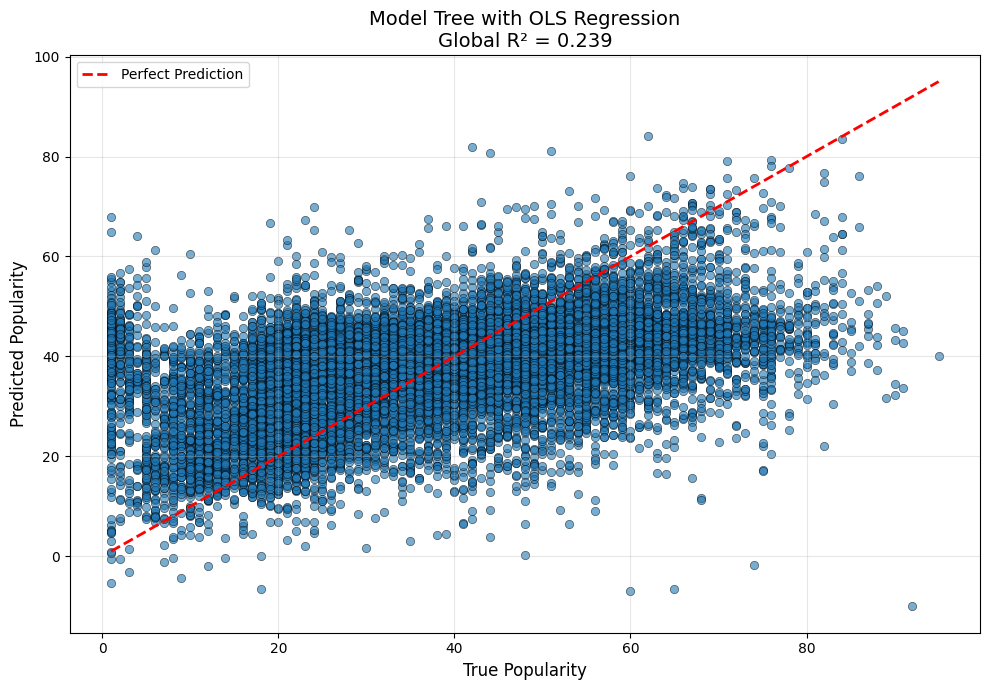

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Model Tree with OLS Regression\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()